#LSTM para séries temporais

##Bike Sharing Dataset
###O dataset utilizado nesse post é o Bike Sharing Dataset, que contém o histórico de 2 anos de um serviço de compartilhamento de bicicletas. Além do volume de bicicletas alugadas de hora em hora, esse dataset também contém informações das condições do tempo (temperatura, humidade e chuva/neve).

###Abaixo, a descrição das variáveis fornecida pelo criador do dataset.

1. instant: record index
2. dteday : date
3. season : season (1:springer, 2:summer, 3:fall, 4:winter)
4.  yr : year (0: 2011, 1:2012)
5.  mnth : month ( 1 to 12)
6.  hr : hour (0 to 23)
7.  holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
8.  weekday : day of the week
9.  workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
10.  weathersit : 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
1. temp : Normalized temperature in Celsius. The values are divided to 41 (max)
2. atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
3. hum: Normalized humidity. The values are divided to 100 (max)
4. windspeed: Normalized wind speed. The values are divided to 67 (max)
5. casual: count of casual users
6. registered: count of registered users
7. cnt: count of total rental bikes including both casual and registe

In [3]:
import pandas as pd

def load_dataset():
    ds = pd.read_csv('/content/hour.csv')
    ds['dteday'] = pd.to_datetime(ds['dteday'])
    return ds
    
def one_hot_encoding(df, field):
    one_hot_encoded = pd.get_dummies(df[field])
    return  pd.concat([df.drop(field, axis=1), one_hot_encoded], axis=1)
    
def preprocess_dataset(df):

    df_reduced = df[['dteday', 'cnt', 'season','yr', 'mnth','hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
    df_reduced = one_hot_encoding(df_reduced, 'season')
    df_reduced = one_hot_encoding(df_reduced, 'mnth')
    df_reduced = one_hot_encoding(df_reduced, 'hr')
    df_reduced = one_hot_encoding(df_reduced, 'weekday')
    df_reduced = one_hot_encoding(df_reduced, 'weathersit')
    
    return df_reduced

dataset = load_dataset()
dataset = preprocess_dataset(dataset)

,dteday,cnt,yr,holiday,workingday,temp,atemp,hum,windspeed,1,2,3,4,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,1,2,3,4
0,2011-01-01,16,0,0,0,0.24,0.2879,0.81,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2011-01-01,40,0,0,0,0.22,0.2727,0.80,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,2011-01-01,32,0,0,0,0.22,0.2727,0.80,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,2011-01-01,13,0,0,0,0.24,0.2879,0.75,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,2011-01-01,1,0,0,0,0.24,0.2879,0.75,0.0000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,119,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
17375,2012-12-31,89,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
17376,2012-12-31,90,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
17377,2012-12-31,61,1,0,1,0.26,0.2727,0.56,0.1343,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


##Treinamento e Validação

In [6]:
from datetime import datetime

def filter_by_date(ds, start_date, end_date):
    
    start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d") 
    start_end_parsed = datetime.strptime(end_date, "%Y-%m-%d")
    
    return ds[(ds['dteday'] >= start_date_parsed) & (ds['dteday'] <= start_end_parsed)]

train = filter_by_date(dataset, '2011-01-01', '2012-10-31')
dev = filter_by_date(dataset, '2012-11-01', '2012-11-30')
val = filter_by_date(dataset, '2012-11-01', '2012-12-31')

,dteday,cnt,yr,holiday,workingday,temp,atemp,hum,windspeed,1,2,3,4,1,2,3,4,5,6,7,8,9,10,11,12,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,1,2,3,4
15919,2012-11-01,60,1,0,1,0.36,0.3636,0.57,0.0896,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
15920,2012-11-01,30,1,0,1,0.30,0.3182,0.75,0.1045,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
15921,2012-11-01,20,1,0,1,0.32,0.3333,0.66,0.1343,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
15922,2012-11-01,15,1,0,1,0.34,0.3333,0.61,0.1343,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
15923,2012-11-01,10,1,0,1,0.34,0.3485,0.66,0.1045,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,119,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
17375,2012-12-31,89,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
17376,2012-12-31,90,1,0,1,0.26,0.2576,0.60,0.1642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
17377,2012-12-31,61,1,0,1,0.26,0.2727,0.56,0.1343,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


###Após separar os conjuntos, podemos transforma-los em vetores numpy para serem usados na rede neural. Perceba que o reshape do vetor de entrada é no formato (n de linhas, 1, n de variáveis) ao invés de (n de linhas, n de variáveis).

###O dado de entrada precisa ser formatado assim, pois a segunda dimensão se refere ao comprimento da sequência. Em nosso caso, o valor é 1 pois cada etapa da sequência gera uma saída. Para alguns problemas, ao invés de gerar uma saída por etapa da sequência, geramos apenas uma saída final para a sequência toda.

In [7]:
import numpy as np

def reshape_dataset(ds):
    Y = ds['cnt'].values
    ds_values = ds.drop(['dteday', 'cnt'], axis=1).values
    X = np.reshape(ds_values, (ds_values.shape[0], 1, ds_values.shape[1]))
    return X, Y

X_train, Y_train = reshape_dataset(train)
X_dev, Y_dev = reshape_dataset(dev)
X_val, Y_val = reshape_dataset(val)
X_train

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 1., ..., 1., 0., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 1., ..., 0., 0., 0.]]])

###Por fim, é útil criar um callback do Keras para vermos o gráfico de evolução de treinamento em tempo real, isso é bastante útil para fazer o ajuste dos parâmetros.

In [8]:
%matplotlib inline

import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()


##LSTM no Keras

###O uso da LSTM no Keras é bastante simples, bastando ao usuário definir a dimensão do vetor de entrada, a quantidade de neurônios e a função de saída. O vetor de entrada, após as transformações de variáveis, tem 58 dimensões. A quantidade de neurônios, após alguns testes, foi definida como 200 que alcançou o mesmo fit de redes maiores sem onerar tanto a perfomance do treinamento. Por fim, a saída será uma camada com um único output com o valor estimado dos aluguéis.

###Adicionei uma camada de Dropout entre a saída da rede (Wt) e a saída final (Ot), procurando mitigar problemas de sobreajuste. Não utilizei essa técnica nas camadas internas da rede, pois elas acabavam atrasando muito o aprendizado, mas o ideal seria entender melhor o uso de dropout nas camadas internas da LSTM.

###O otimizador utilizado foi o Adam, que geralmente é o mais rápido e estável para convergir. Após experimentos, percebi que o valor padrão da taxa de aprendizado (0,001) era muito baixo. Subindo para 0,01 a taxa de aprendizado, a convergência ficou muito mais rápida e também alcançou taxas de erros menores. Combinando esse aumento de taxa de aprendizado com uma taxa de decaimento de 0,001, a rede consegue aprender rapidamente e continuar convergindo na parte do ajuste fino.

###A rede está usando como função de perda a métrica de erro absoluto médio, dessa forma temos uma visão clara de quanto estamos errando comparado ao valor absoluto das predições. Abaixo, o código completo para definição da LSTM.

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout

def get_model():

    input = Input(shape=(1, 58))
    x = LSTM(200, dropout=.0)(input)
    x = Dropout(.5)(x)
    activation = Dense(1, activation='linear')(x)
    model = Model(inputs=input, outputs=activation)
    
    optimizer = keras.optimizers.Adam(lr=0.01,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=None,
                                      decay=0.001,
                                      amsgrad=False)

    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    model.summary()

    return model

get_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 58)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               207200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 207,401
Trainable params: 207,401
Non-trainable params: 0
_________________________________________________________________


##Resultados e conclusão
###A nossa rede está definida, agora podemos treina-la e avaliar os resultados no conjunto de validação. Assim como na definição dos parâmetros da rede. Usando a arquitetura acima, com 50 épocas e batch de 128, chegamos ao ponto de estabilidade das perdas no conjunto de treino e desenvolvimento.

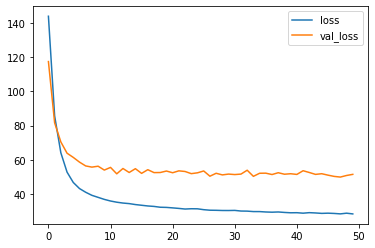

In [10]:
def train_model(model, X_train, Y_train, validation, callbacks):

    model.fit(X_train, Y_train, epochs=50, batch_size=128, validation_data=validation, callbacks=callbacks)
    return model
  
model = train_model(get_model(), X_train, Y_train, (X_dev, Y_dev), [plot_losses])

###Durante o processo de treinamento e validação, o erro da validação ficou na faixa de 40/50 aluguéis, enquanto o erro do treinamento ficou na faixa dos 20 aluguéis. Para efeitos de comparação, a média de aluguéis a cada hora está em 189. Abaixo, o gráfico de perda desse processo de treinamento.

###Para problemas de séries temporais é interessante observar os dados sequencialmente para entender em que situações a rede está errando. Segue abaixo o código para plotar o resultado observado e o predito pela rede, possibilitando assim a visualização dos resultados.

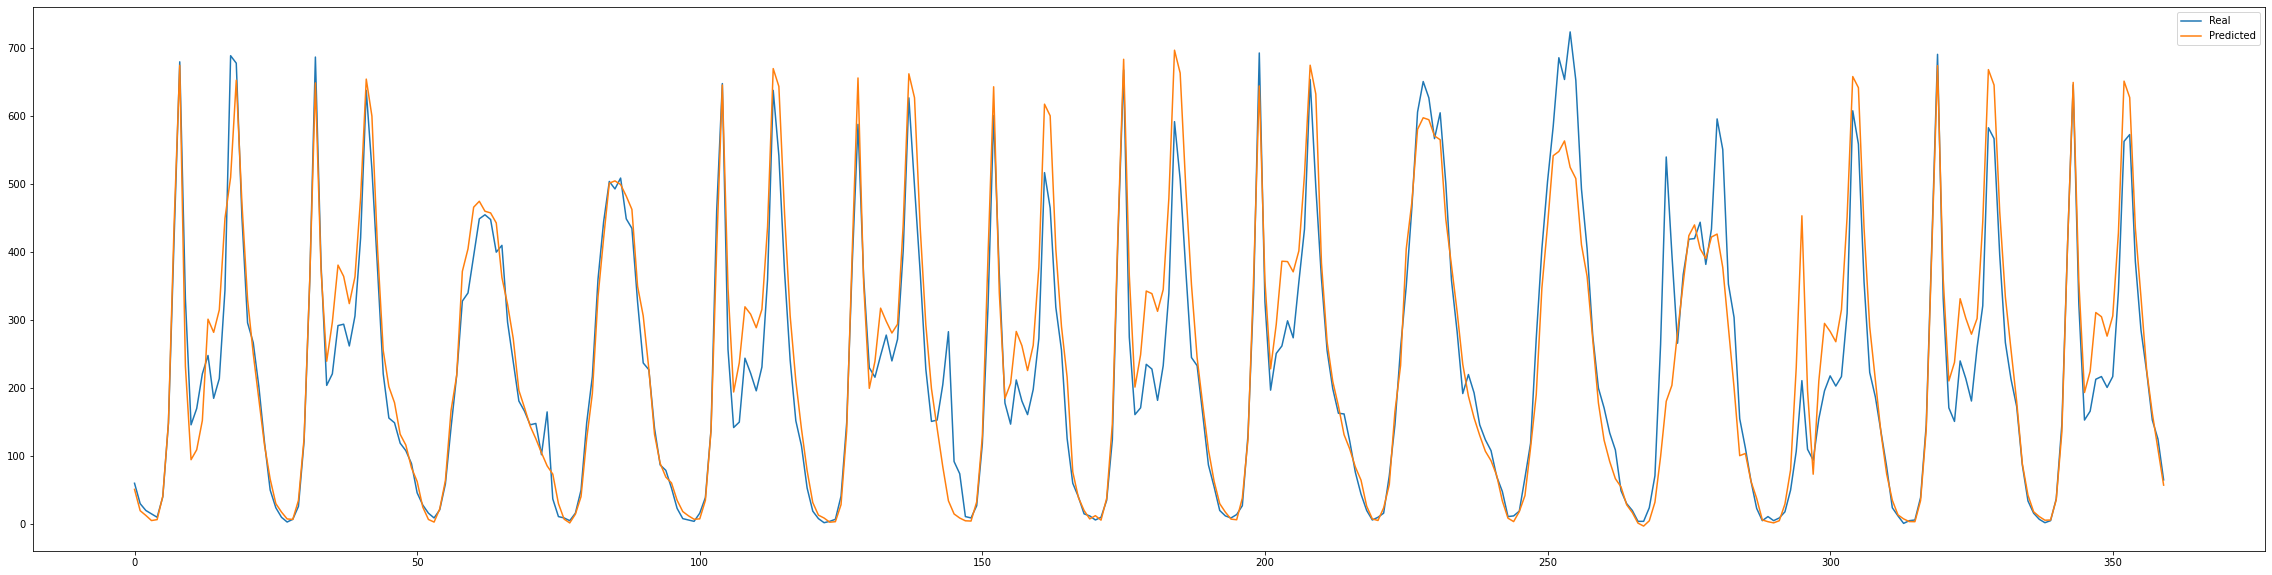

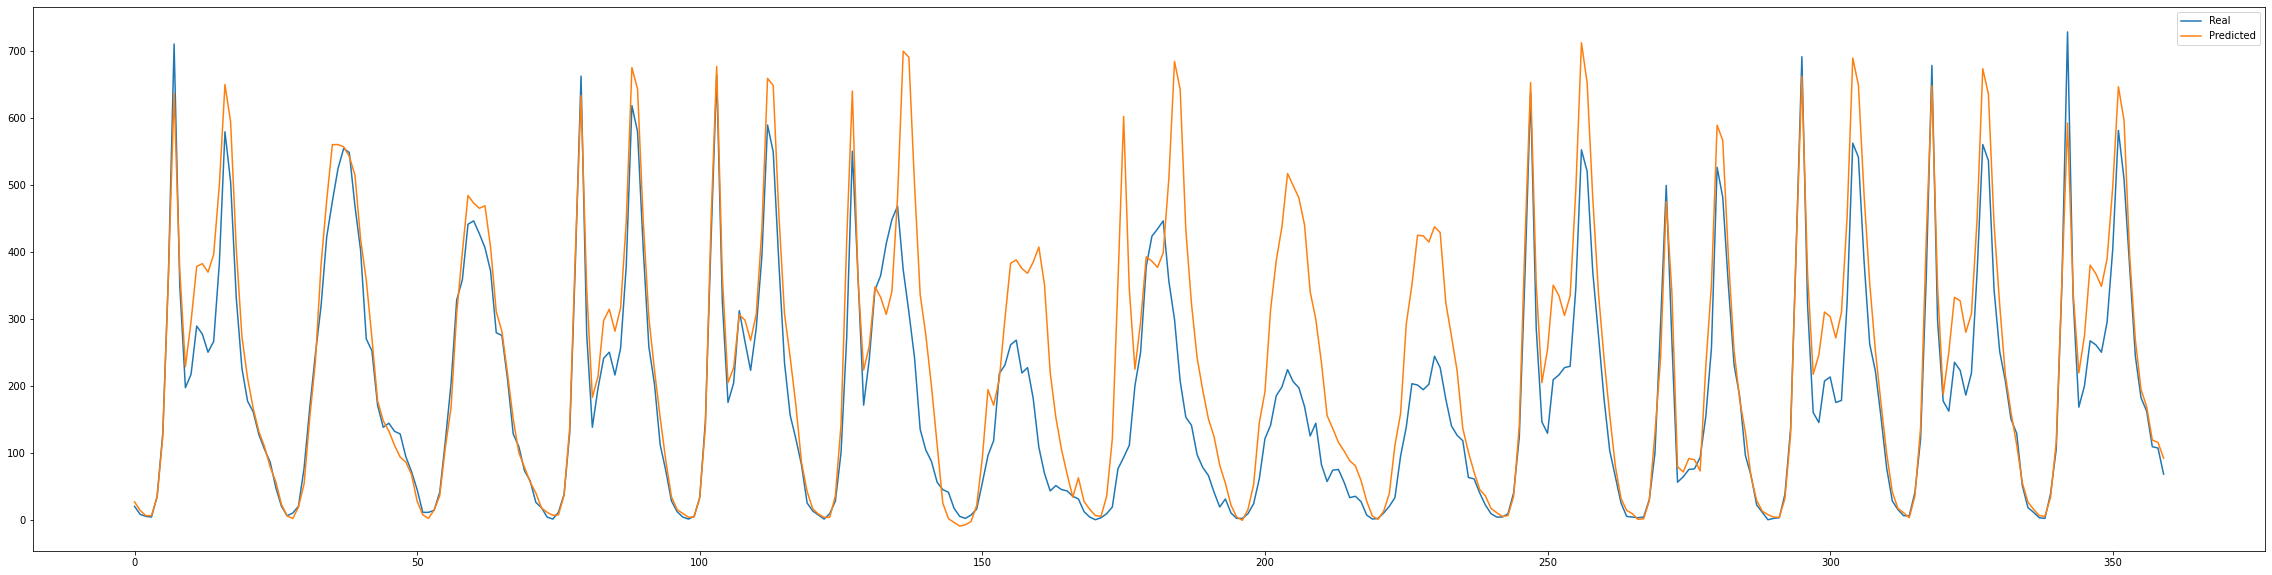

61.09475711981455

In [11]:
from sklearn.metrics import mean_absolute_error

def show_predict(model, X, Y):
    
    Y_predict = model.predict(X)
    
    plt.figure(figsize=(40,10))
    plt.plot(list(range(len(Y))), Y, label="Real")
    plt.plot(list(range(len(Y_predict))), Y_predict, label="Predicted")
    plt.legend()
    plt.show()

    return mean_absolute_error(Y, Y_predict)

show_predict(model, X_val[:360], Y_val[:360])
show_predict(model, X_val[360:720], Y_val[360:720])

###Comparando o real do conjunto de validação com o projetado, obtemos um erro similar similar ao conjunto de dev.

In [ ]:
###A partir desse resultado inicial, seria interessante fazer uma análise mais extensa, para um ajuste fino da rede e entender melhor as particularidades do dataset, mas esses resultados já mostram que as redes recorrentes têm uma ótima capacidade de se adaptar a esses problemas de séries temporais. Combinando essa poder das redes recorrentes com a facilidade de implementação, usar uma LSTM é um ótimo ponto de partida para esses problemas de séries temporais.